In [129]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
from joblib import Parallel, delayed

In [130]:
# Load MNIST from CSV (assuming first column is label, rest are pixels)
df = pd.read_csv("mnist_data/mnist_train.csv")
X = df.iloc[:, 1:].values.astype(np.float32)  # features
y = df.iloc[:, 0].values  # labels

# Subsample (e.g. 1000 points for tractability)
n_samples = 500
X = X[:n_samples]
y = y[:n_samples]

In [131]:
# Choose distance space: 'raw', 'pca', or 'tsne'
distance_mode = 'pca'  # options: 'raw', 'pca', 'tsne'

if distance_mode == 'raw':
    X_embed = X
elif distance_mode == 'pca':
    X_embed = PCA(n_components=2, random_state=42).fit_transform(X)
elif distance_mode == 'tsne':
    X_embed = TSNE(n_components=2, perplexity=30,
                   random_state=42).fit_transform(X)
else:
    raise ValueError("distance_mode must be 'raw', 'pca', or 'tsne'")

In [132]:
# Build kNN graph (20 nearest neighbors)
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1, metric='euclidean').fit(X_embed)
distances, indices = nbrs.kneighbors(X_embed)

In [133]:
# Build weighted graph
# G = nx.Graph()
# for i in tqdm(range(n_samples), desc='creating distance matrix'):
#     for j, d in zip(indices[i][1:], distances[i][1:]):  # skip self
#         mse = mean_squared_error(X_embed[i], X_embed[j])
#         G.add_edge(i, j, weight=mse)

# Parallel edge construction (using X_embed)
def build_edges(i):
    edges = []
    for j, d in zip(indices[i][1:], distances[i][1:]):  # skip self
        mse = mean_squared_error(X_embed[i], X_embed[j])
        edges.append((i, j, mse))
    return edges


results = Parallel(n_jobs=-1)(delayed(build_edges)(i)
                              for i in tqdm(range(n_samples), desc="creating distance matrix"))
G = nx.Graph()
for edge_list in tqdm(results, desc="building graph"):
    for i, j, mse in edge_list:
        G.add_edge(i, j, weight=mse)

building graph: 100%|██████████| 500/500 [00:00<00:00, 36345.16it/s]


Path: [0, np.int64(452), 243, 117, 110, np.int64(324), 276, 33, np.int64(338), np.int64(380), 209, np.int64(473), 232, np.int64(429), 15, np.int64(484), 423, 259, 399, 458, np.int64(467), np.int64(258), np.int64(249), 227, np.int64(419), 99, np.int64(427), 149, 303, np.int64(486), 341, 499]
Path length: 32
Labels along path: [0 0 5 0 3 2 2 0 2 2 0 5 2 6 2 8 9 0 2 3 7 5 3 3 5 5 9 4 9 9 4 3]


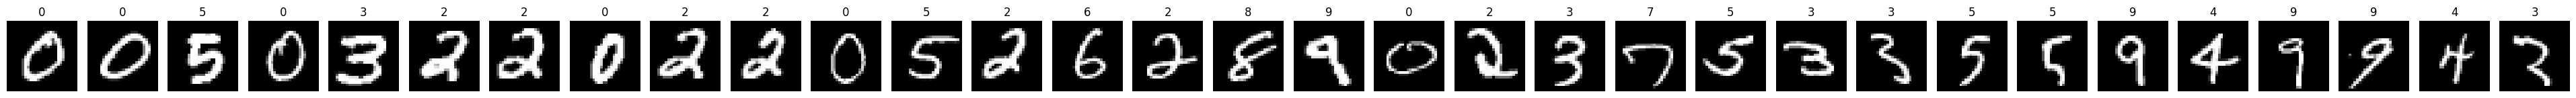

In [134]:
# 5. Shortest path example: between two random points
src, dst = 0, 499
path = nx.shortest_path(G, source=src, target=dst, weight='weight')
path_length = nx.shortest_path_length(G, source=src, target=dst, weight='weight')

print("Path:", path)
print("Path length:", len(path))
print("Labels along path:", y[path])

# 6. Plot images along the path
fig, axes = plt.subplots(1, len(path), figsize=(len(path)*1.2, 2))
for ax, idx in zip(axes, path):
    ax.imshow(X[idx].reshape(28, 28), cmap="gray")
    ax.set_title(str(y[idx]))
    ax.axis("off")

plt.tight_layout()
plt.show()

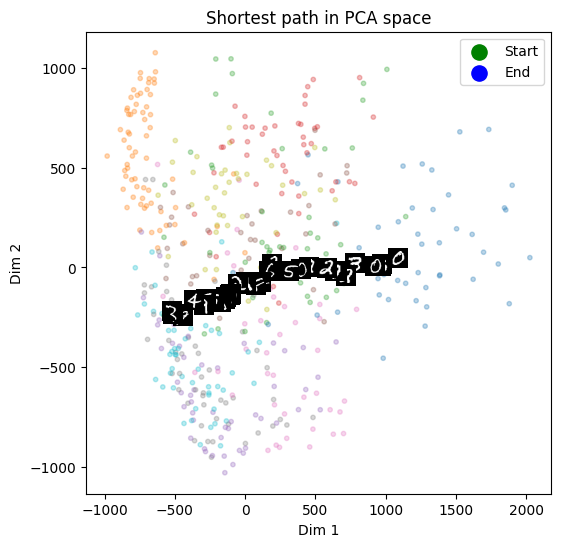

In [135]:
if distance_mode in ['pca', 'tsne']:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(X_embed[:, 0], X_embed[:, 1], c=y,
               cmap="tab10", alpha=0.3, s=10)

    # overlay path line
    path_coords = X_embed[path]
    ax.plot(path_coords[:, 0], path_coords[:, 1], c="red", linewidth=3)

    # add MNIST digit thumbnails at each path point
    for idx, (x0, y0) in zip(path, path_coords):
        img = X[idx].reshape(28, 28)
        imagebox = OffsetImage(img, zoom=0.5, cmap="gray")
        ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
        ax.add_artist(ab)

    # highlight start and end
    ax.scatter(path_coords[0, 0], path_coords[0, 1],
               c="green", s=120, label="Start")
    ax.scatter(path_coords[-1, 0], path_coords[-1, 1],
               c="blue", s=120, label="End")
    ax.legend()

    ax.set_title(f"Shortest path in {distance_mode.upper()} space")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    plt.show()